# Effective noise channels

## Introduction
Effective noise channels were introduced in the introductory tutorial [Simulating sequences with errors and noises](noisy_sim.nblink). They will be further detailed in this notebook. We recommend you to check the introductory tutorial before going through this one.

The effective noise channels implemented here are based on the concept of Kraus operators which are actors in the Lindblad equation. If you're not familiar with Lindblad equations or want to go further, please check the resource [here](https://ocw.mit.edu/courses/22-51-quantum-theory-of-radiation-interactions-fall-2012/resources/mit22_51f12_ch8/).

Recall the Lindblad equation:

$$
\frac{d \rho}{dt} = -i[\mathcal{H}, \rho] + \sum_k \left( L_k \rho L_k^\dagger - \frac{1}{2} \left\{ L_k^\dagger L_k, \rho \right\} \right)
$$ 

The operators $L_k$ are often called *Collapse operators*. Basically, an effective noise channel can be fully described by a set of collapse operators that are related to each other by the completeness relation:  $\sum_k L_k L_k^\dagger = \mathbb{I}$.

So varying $L_k$ gives birth to different effective noise channels. We will discuss in this tutorial two specific ones:

* [The dephasing channel](###The-Dephasing-channel)
* [The depolarizing channel](###The-Depolarizing-channel)


In [1]:
import qutip
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from pulser import Pulse, Sequence, Register
from pulser_simulation import Simulation, SimConfig
from pulser_simulation.simresults import SimulationResults
from pulser.devices import Chadoq2

### The dephasing channel

_Dephasing channel_ models noises that modify the system into a mixture of states such that the phase cannot be accurately predicted.

The dephasing noise can be thought of as arising from random z-rotations across the state, with a certain probability $p$. This can be modelled as the action of the following operators:

$$
L_0 = \sqrt{1-\frac{p}{2}} \,\, \mathbb{I} \\
L_1 = \sqrt{\frac{p}{2}} \,\, \sigma_z
$$

### The depolarizing channel

Under the depolarizing noise, a system in the ground state evolves to the maximally mixed state. The operators interacting with the system are written as below:

$$
L_0 = \sqrt{1-\frac{3}{4}p} \,\, \mathbb{I}, \\
L_1 = \sqrt{\frac{p}{4}} \sigma_x, \\
L_2 = \sqrt{\frac{p}{4}}\sigma_z, \\
L_3 = \sqrt{\frac{p}{4}} \sigma_y
$$


### Bloch sphere representation

To better understand the effect of each channel on a single-qubit density matrix, let us represent it on the Bloch sphere.

Any density matrix of a mixed state may be written as $\rho = \frac{\mathbb{I} + \vec{r}.\vec{\sigma}}{2}$, where $\vec{r}$ is the vector representing the mixed state on the Bloch sphere.

In [2]:
def vector_to_dm(r_x, r_y, r_z):
    """Transforms a vector on the Bloch sphere into a density matrix."""

    return 0.5 * (
        qutip.qeye(2)
        + r_x * qutip.sigmax()
        + r_y * qutip.sigmay()
        + r_z * qutip.sigmaz()
    )


def dm_to_vector(rho):
    """Transforms a density matrix rho to vector on the Bloch sphere."""

    I = 2 * rho - np.eye(2)
    r_x = np.real((I[0, 1] + I[1, 0]) / 2)
    r_y = np.real((I[1, 0] - I[0, 1]) / 2)
    r_z = np.real(I[0, 0])

    return r_x, r_y, r_z


def depolarizing_channel(rho, prob):
    """Depolarizing channel."""
    return (1 - 3 * prob / 4) * rho + prob / 4 * (
        qutip.sigmax() * rho * qutip.sigmax()
        + qutip.sigmay() * rho * qutip.sigmay()
        + qutip.sigmaz() * rho * qutip.sigmaz()
    )


def dephasing_channel(rho, prob):
    """Dephasing channel."""
    return (
        1 - prob / 2
    ) * rho + prob / 2 * qutip.sigmaz() * rho * qutip.sigmaz()

First, we generate uniformly distributed points on the surface of the Bloch sphere.

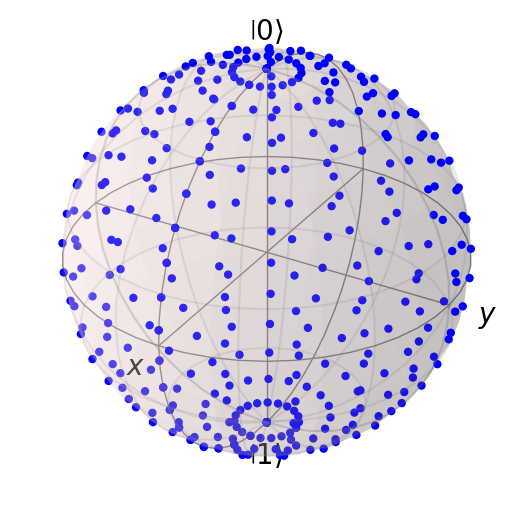

In [3]:
u = np.linspace(0, 2 * np.pi, 20)
v = np.linspace(0, np.pi, 20)
r = 1
n = len(u)
# x, y, z coordinates with fixed radius r from center X0, Y0, Z0

x = r * np.reshape(np.outer(np.cos(u), np.sin(v)), newshape=(n**2, 1))
y = r * np.reshape(np.outer(np.sin(u), np.sin(v)), newshape=(n**2, 1))
z = r * np.reshape(
    np.outer(np.ones(np.size(u)), np.cos(v)), newshape=(n**2, 1)
)

# Then we build the bloch with the above points
b = qutip.Bloch()
points = [x, y, z]
b.add_points(points)
b

To observe the effect of the depolarizing and dephasing channels, we apply each channel separately to the points on the Bloch sphere and plot the resulting vectors.

#### Dephasing channel

In [4]:
dephasing_prob = 0.5
x_dp = x.copy()
y_dp = y.copy()
z_dp = z.copy()
n, p = x.shape
for i in range(n):
    for j in range(p):
        dm = vector_to_dm(x[i, j], y[i, j], z[i, j])
        dm_n = dephasing_channel(dm, dephasing_prob)
        r_x, r_y, r_z = dm_to_vector(dm_n)
        x_dp[i, j] = r_x
        y_dp[i, j] = r_y
        z_dp[i, j] = r_z

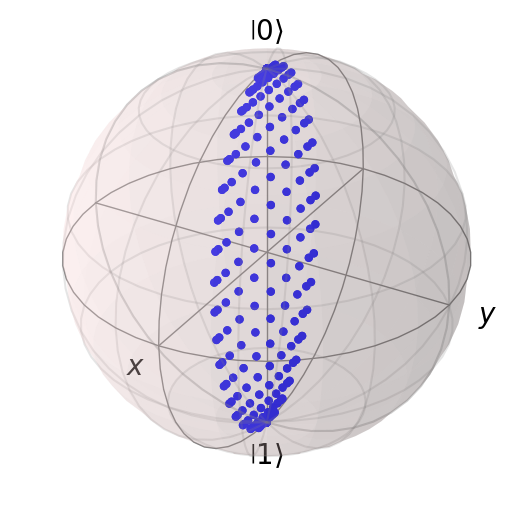

In [5]:
b = qutip.Bloch()
points = [x_dp, y_dp, z_dp]
b.add_points(points)
b

For the dephasing channel, the $z$-coordinate of the Bloch vector is conserved while the others are contracted.

#### Depolarizing channel

In [6]:
depolarizing_prob = 0.5
x_dp = x.copy()
y_dp = y.copy()
z_dp = z.copy()
n, p = x.shape
for i in range(n):
    for j in range(p):
        dm = vector_to_dm(x[i, j], y[i, j], z[i, j])
        dm_n = depolarizing_channel(dm, depolarizing_prob)
        r_x, r_y, r_z = dm_to_vector(dm_n)
        x_dp[i, j] = r_x
        y_dp[i, j] = r_y
        z_dp[i, j] = r_z

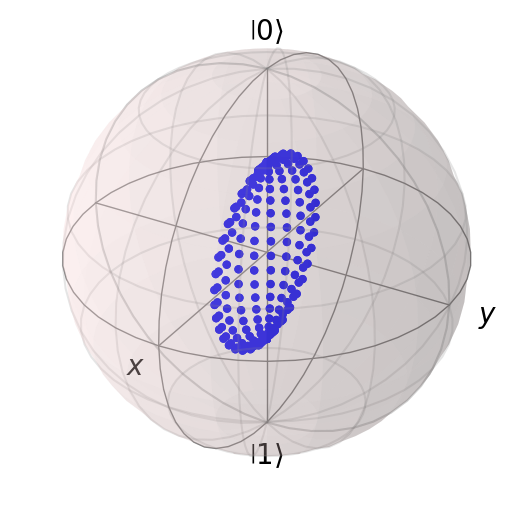

In [7]:
b = qutip.Bloch()
points = [x_dp, y_dp, z_dp]
b.add_points(points)
b

The depolarizing channel contracts the Bloch sphere across all directions. We could try to come up with an inflation channel that would revert the state's depolarization. However, such a channel would not be positive and thus not a valid superoperator, confirming that the coherence lost cannot be recovered.

## Single atom noisy simulations

In this section we will study the impact of effective noise channels on a single qubit under a resonant pulse. We start by preparing a single atom:

In [8]:
reg = Register.from_coordinates([(0, 0)], prefix="q")

Then we act on this atom with a Constant Pulse, such that it oscillates between the ground state and excited Rydberg state (Rabi oscillations):

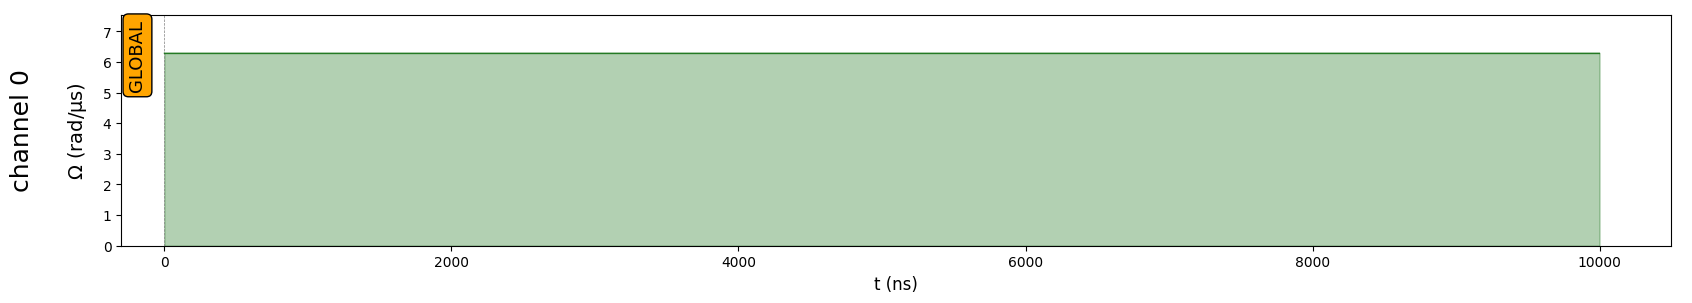

In [9]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel("channel 0", "rydberg_global")
duration = 10000
pulse = Pulse.ConstantPulse(duration, 2 * np.pi, 0 * np.pi, 0.0)
seq.add(pulse, "channel 0")
seq.draw()

Let's first run the simulation without noise.

In [10]:
clean_simu = Simulation(seq, sampling_rate=0.05)
clean_res = clean_simu.run()

We can observe the ground state population using its projector and then the `plot()` method from the `Results` object:

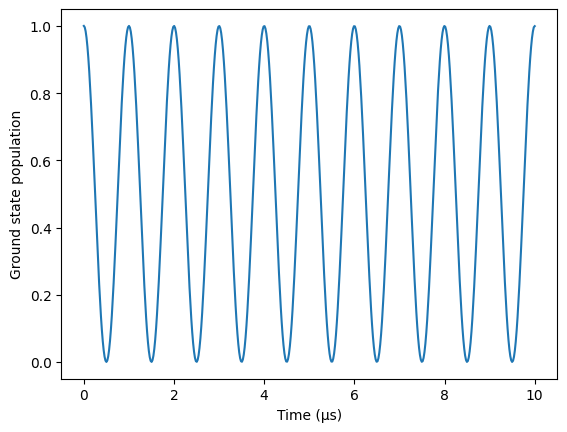

In [11]:
obs = (
    clean_simu.initial_state.proj()
)  # Make projector from initial state of the Simulation object (uses QuTiP)
clean_res.plot(obs)  # Plot the expectation value of the observable
plt.ylabel("Ground state population")
plt.show()

The are two ways to define the dephasing and depolarizing channels. The first way is to create a `SimConfig` object, specifying the noise type as `"dephasing"` and choosing the dephasing probability `dephasing_prob`:

In [12]:
config_dephasing = SimConfig(noise="dephasing", dephasing_prob=0.1)
clean_simu.set_config(config_dephasing)
clean_simu.show_config()

Options:
----------
Number of runs:        15
Samples per run:       5
Noise types:           dephasing
Dephasing probability: 0.1


Likewise we can create a SimConfig object for the depolarizing noise. Notice how we reset the configuration using the `reset_config()` method:

In [13]:
clean_simu.reset_config()
config_depolarizing = SimConfig(noise="depolarizing", depolarizing_prob=0.1)
clean_simu.set_config(config_depolarizing)
clean_simu.show_config()

Options:
----------
Number of runs:        15
Samples per run:       5
Noise types:           depolarizing
Depolarizing probability: 0.1


The second way, which is more general, allows the user to define any Kraus channel to describe effective noise.

In [14]:
clean_simu.reset_config()
config_dephasing = SimConfig(
    noise="eff_noise",
    eff_noise_opers=[qutip.qeye(2), qutip.sigmaz()],
    eff_noise_probs=[
        1 - 0.05,
        0.05,
    ],  # Need to add up to 1 to be a valid probability distribution
)
clean_simu.add_config(config_dephasing)
clean_simu.show_config()

Options:
----------
Number of runs:        15
Samples per run:       5
Noise types:           eff_noise
Effective noise distribution:       [0.95, 0.05]
Effective noise operators:       [Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]]


This allows you to design other effective noise channels by inputting the respective Kraus operators.

Let us now simulate the entire sequence with our two effective noise channels. First, we define some useful functions for our simulations:

In [15]:
def noisy_dynamics(clean_simu, config):
    """Gives the result of a noisy simulation."""
    simu = deepcopy(clean_simu)
    # Adding noise
    simu.add_config(config)
    result = simu.run()
    return result


def plot_basis_population(
    psi,
    noise_results: SimulationResults,
    noise_probabilities,
    decay_profile,
    axis,
    convergent_constant,
    label=False,
):
    """Plots the basis state population evolution."""
    noise_pops = []
    for noise_result in noise_results:
        population = []
        for rho_t in noise_result.states:
            value = psi.dag() * rho_t * psi
            population.append(np.abs(value[0][0]))
        noise_pops.append(population)

    times = noise_results[0]._sim_times

    for noise_probability, noise_pop in zip(noise_probabilities, noise_pops):
        axis.plot(
            noise_pop,
            label=rf"$p$ = {noise_probability}",
            color=[0.9 - 0.5 * noise_probability] * 3,
        )
    N_realizations = len(noise_probabilities)
    if decay_profile is not None:
        for i in range(N_realizations):
            axis.plot(
                decay_profile(noise_probabilities[i], times),
                color="red",
                alpha=0.6,
            )
            if i == N_realizations - 1:
                axis.plot(
                    decay_profile(noise_probabilities[i], times),
                    color="red",
                    alpha=0.6,
                    label="Damping",
                )

    axis.axhline(
        convergent_constant,
        color="black",
        linestyle="--",
        label="Final mixed state",
    )

    # Put labels outside of the plot
    if label:
        axis.legend(
            bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0
        )

Using the above functions we are ready to run our noisy simulations. We will study the effects of dephasing and depolarizing noise for different noise probability realizations.

In [16]:
clean_simu.reset_config()

noise_probabilities = np.linspace(0, 1, 5)
depolarizing_results = []
dephasing_results = []

for noise_probability in noise_probabilities:
    print("Noise probability = ", noise_probability)

    # We configure the dephasing and depolarizing noises
    config_dephasing = SimConfig(
        noise="dephasing", dephasing_prob=noise_probability
    )
    config_depolarizing = SimConfig(
        noise="depolarizing", depolarizing_prob=noise_probability
    )

    # We run the simulations
    dephasing_result = noisy_dynamics(clean_simu, config_dephasing)
    depolarizing_result = noisy_dynamics(clean_simu, config_depolarizing)

    # Storage
    depolarizing_results.append(depolarizing_result)
    dephasing_results.append(dephasing_result)

Noise probability =  0.0
Noise probability =  0.25
Noise probability =  0.5
Noise probability =  0.75
Noise probability =  1.0


In [17]:
# Basis states definition
r_state = qutip.basis(2, 0)
g_state = qutip.basis(2, 1)
basis = {
    "g": g_state,
    "r": r_state,
}

### Dephasing Channel

In the following we illustrate the results of the single qubit dephasing channel.

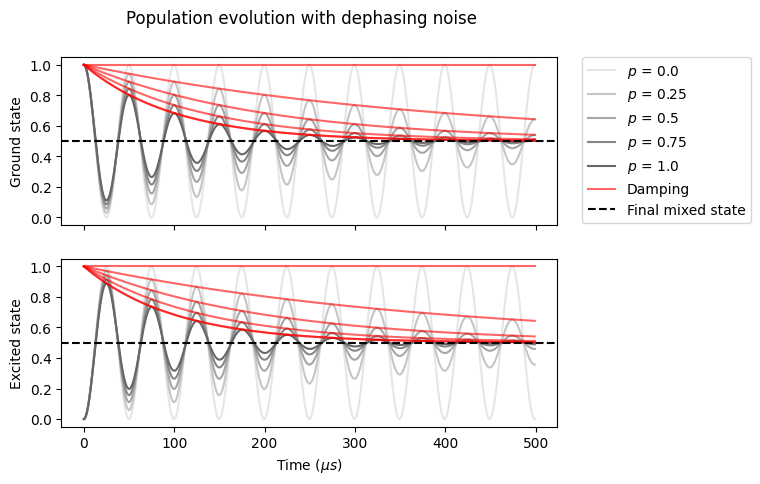

In [18]:
# We define the decay profile for plotting
def decay_profile(noise_prob, times):
    return 0.5 * np.exp(-0.5 * noise_prob * times) + 0.5


# We plot the population evolution
fig, axs = plt.subplots(2)
fig.suptitle("Population evolution with dephasing noise")
axs.flat[0].set(xlabel=r"Time ($\mu s$)", ylabel="Ground state")
axs.flat[1].set(xlabel=r"Time ($\mu s$)", ylabel="Excited state")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plot_basis_population(
    basis["g"],
    dephasing_results,
    noise_probabilities,
    decay_profile,
    axs[0],
    1 / 2,
    True,
)
plot_basis_population(
    basis["r"],
    dephasing_results,
    noise_probabilities,
    decay_profile,
    axs[1],
    1 / 2,
)
plt.show()

This plot shows the Rabi oscillations over time. You can see the effects of the dephasing channel on the populations of the excited and ground states. When we increase the noise of the dephasing channel, the Rabi oscillations are increasingly damped.

The dephasing channel destroys off-diagonal elements of the density matrix, and tends towards a stationary state with zero off-diagonals. The mixed state obtained is the maximally mixed state.

In other words the density matrix converges to $\rho = \frac{1}{2} \mathbb I = \frac{1}{2}(|0\rangle\langle 0| + |1\rangle\langle 1|)$.

Notice that the ground state and excited state populations oscillate in phase opposition.

### Depolarizing Channel

In the following we illustrate the results of the single qubit depolarizing channel.

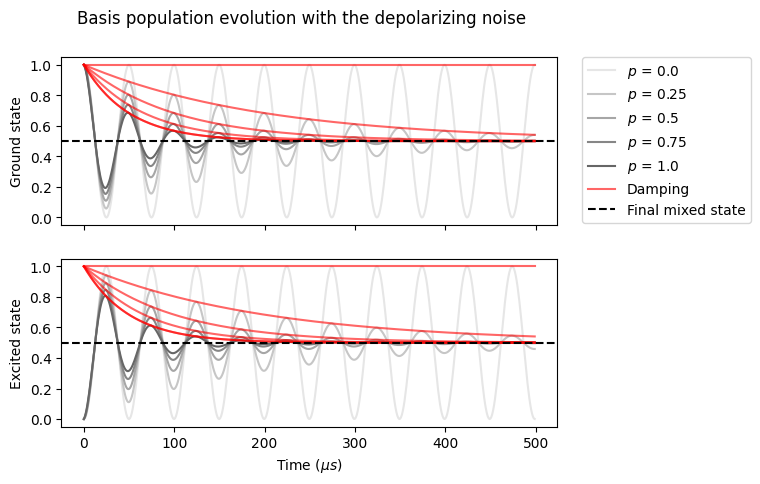

In [19]:
# We define the decay profile
def decay_profile(noise_prob, times):
    return 0.5 * np.exp(-noise_prob * times) + 0.5


fig, axs = plt.subplots(2)
fig.suptitle("Basis population evolution with the depolarizing noise")
axs.flat[0].set(xlabel=r"Time ($\mu s$)", ylabel="Ground state")
axs.flat[1].set(xlabel=r"Time ($\mu s$)", ylabel="Excited state")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plot_basis_population(
    basis["g"],
    depolarizing_results,
    noise_probabilities,
    decay_profile,
    axs[0],
    1 / 2,
    True,
)
plot_basis_population(
    basis["r"],
    depolarizing_results,
    noise_probabilities,
    decay_profile,
    axs[1],
    1 / 2,
)
plt.show()

As was the case for the dephasing channel, we observe a damping of the population of both basis states, indicating a convergence torwards the maximally mixed state. However, for matching probability values, the depolarizing channel results in a faster decoherence than the dephasing channel.

If we recall the effect of both channels on the Bloch sphere, we see that the depolarizing channel acts uniformly for any state, while the dephasing channel's effect is maximized for Bloch vectors lying on the equator. Therefore, as the Bloch vector oscillates between $\ket{0}$ and $\ket{1}$, it still gets progressively smaller. However, its decoherence rate only matches that of the depolarizing channel when crossing the equator, resulting in a compartively longer coherence time.

## Two-atom noisy simulations

We already know what happens in a single qubit configuration, but we would like to study the multi-qubit case. To do so we start with two qubits.

We will analyze two configurations. One with nearby atoms and another with distant atoms and see how effective noise channels interact with the system.

The concepts of *far* and *nearby* are defined with respect to the Rydberg blockade radius. Two atoms are *nearby* when they are within a blockade radius of one another and *far* otherwise.

In [20]:
# Rydberg blockade radius
omega = 2 * np.pi
r_interatomic = Chadoq2.rydberg_blockade_radius(omega)
print(f"Rydberg radius ({r_interatomic}) > 5 ")

Rydberg radius (9.756753962298905) > 5 


Let's take $p = Pr(q_i = Nq_i), \forall i$, and $m$ the number of atoms affected by noise, the underlying probability is $p^m$. If $p\ll 1$ then we get: $p^m \longrightarrow 0$

### Nearby atoms

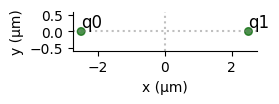

In [21]:
# We create two nearby atoms
reg = Register.from_coordinates([(0, 0), (5, 0)], prefix="q")

reg.draw()

We will use the same pulse as before.

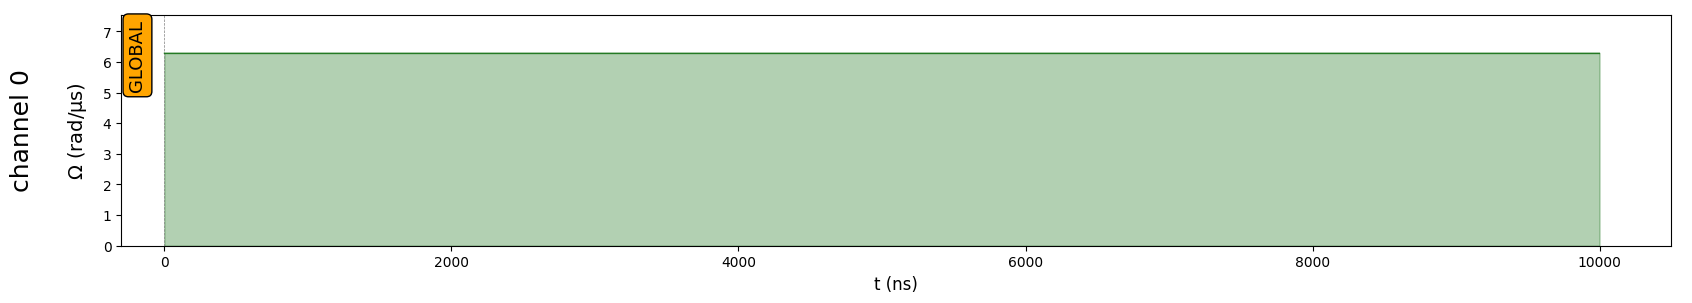

In [22]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel("channel 0", "rydberg_global")
duration = 10000
pulse = Pulse.ConstantPulse(duration, omega, 0, 0.0)
seq.add(pulse, "channel 0")
seq.draw()

In [23]:
clean_simu = Simulation(seq, sampling_rate=0.05)
clean_res = clean_simu.run()

We made some approximations to be able to simulate Kraus channels in multi-qubit systems on pulser. 

The first one is the *uncorrelated noise approximation*. It relies on the fact that the probability of two qubits to undergo an effective noise are independent i.e:

$Pr(q_i = Nq_i, q_j= Nq_j) = Pr(q_i = Nq_i) Pr(q_j = Nq_j)$, $\forall i \neq j$ where $N$ is a noise operator.

Therefore, our second approximation assumes $p^2 \ll 1$ ($p\lessapprox 0.2$): _we consider only first order effects_.

When an effective noise probability is higher than $0.2$, a warning is raised, alerting you are outside the valid regime of our approximation.

In [24]:
clean_simu.reset_config()

noise_probabilities = np.round(np.linspace(0, 0.2, 5), 3)
depolarizing_results = []
dephasing_results = []

for noise_probability in noise_probabilities:
    print("Noise probability = ", noise_probability)

    # We configure the dephasing and depolarizing noises
    config_dephasing = SimConfig(
        noise="dephasing", dephasing_prob=noise_probability
    )
    config_depolarizing = SimConfig(
        noise="depolarizing", depolarizing_prob=noise_probability
    )

    # We run the simulations
    dephasing_result = noisy_dynamics(clean_simu, config_dephasing)
    depolarizing_result = noisy_dynamics(clean_simu, config_depolarizing)

    # Storage
    depolarizing_results.append(depolarizing_result)
    dephasing_results.append(dephasing_result)

Noise probability =  0.0
Noise probability =  0.05
Noise probability =  0.1
Noise probability =  0.15
Noise probability =  0.2


In [32]:
# Basis states definition
r_state = qutip.basis(2, 0)
g_state = qutip.basis(2, 1)
basis = {
    "gg": qutip.tensor(g_state, g_state),
    "rg": qutip.tensor(r_state, g_state),
    "gr": qutip.tensor(g_state, r_state),
    "rr": qutip.tensor(r_state, r_state),
}

#### Dephasing Channel

In the following we illustrate the results of the two-qubit dephasing channel.

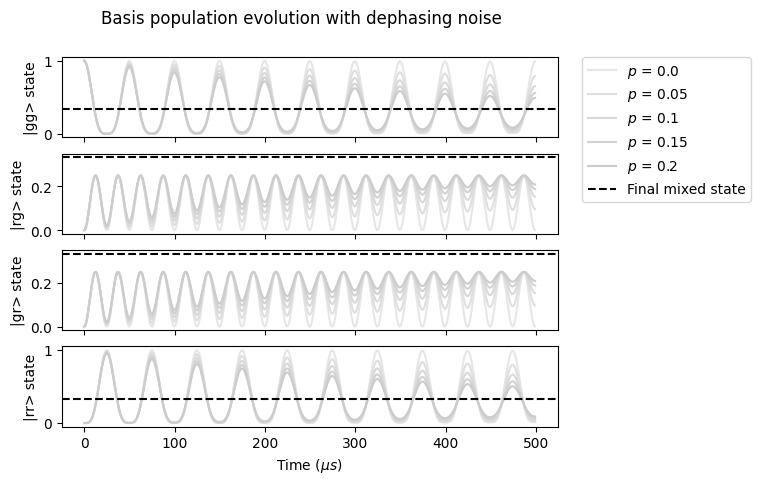

In [33]:
fig, axs = plt.subplots(4)
fig.suptitle("Basis population evolution with dephasing noise")
axs.flat[0].set(xlabel=r"Time ($\mu s$)", ylabel="|gg> state")
axs.flat[1].set(xlabel=r"Time ($\mu s$)", ylabel="|rg> state")
axs.flat[2].set(xlabel=r"Time ($\mu s$)", ylabel="|gr> state")
axs.flat[3].set(xlabel=r"Time ($\mu s$)", ylabel="|rr> state")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plot_basis_population(
    basis["gg"],
    dephasing_results,
    noise_probabilities,
    None,
    axs[0],
    1 / 3,
    True,
)
plot_basis_population(
    basis["rg"], dephasing_results, noise_probabilities, None, axs[1], 1 / 3
)
plot_basis_population(
    basis["gr"], dephasing_results, noise_probabilities, None, axs[2], 1 / 3
)
plot_basis_population(
    basis["rr"], dephasing_results, noise_probabilities, None, axs[3], 1 / 3
)
plt.show()

We can easily notice that: $\braket{gg|\rho(t)|gg}, \braket{gr|\rho(t)|gr}$ and $\braket{rg|\rho(t)|rg}$ converge to $\frac{1}{3}$ when $\braket{rg|\rho(t)|rg}$ stays at zero.

Atom 2 is inside the Rydberg radius, so the $\ket{rr}$ state is forbidden.

The final mixed state is then: 

$$
\rho = \frac{1}{3} (\ket{gg}\bra{gg} + \ket{gr}\bra{gr} + \ket{rg}\bra{rg} )
$$

Let's see whether the same happens with the depolarizing channel.

#### Depolarizing Channel

In the following we illustrate the results of the two-qubit depolarizing channel.

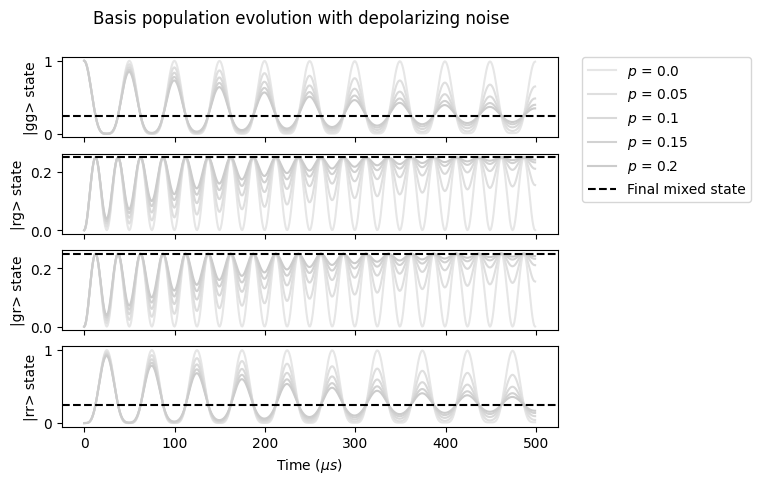

In [34]:
fig, axs = plt.subplots(4)
fig.suptitle("Basis population evolution with depolarizing noise")
axs.flat[0].set(xlabel=r"Time ($\mu s$)", ylabel="|gg> state")
axs.flat[1].set(xlabel=r"Time ($\mu s$)", ylabel="|rg> state")
axs.flat[2].set(xlabel=r"Time ($\mu s$)", ylabel="|gr> state")
axs.flat[3].set(xlabel=r"Time ($\mu s$)", ylabel="|rr> state")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plot_basis_population(
    basis["gg"],
    depolarizing_results,
    noise_probabilities,
    None,
    axs[0],
    1 / 4,
    True,
)
plot_basis_population(
    basis["rg"], depolarizing_results, noise_probabilities, None, axs[1], 1 / 4
)
plot_basis_population(
    basis["gr"], depolarizing_results, noise_probabilities, None, axs[2], 1 / 4
)
plot_basis_population(
    basis["rr"], depolarizing_results, noise_probabilities, None, axs[3], 1 / 4
)
plt.show()

Although the Rydberg blockade should make the state $\ket{rr}$ state unreacheble, we observe its population gradually increase over time. This is explained by the fact that the depolarizing noise is making each state vector evolve independently towards the maximally mixed state. Therefore, as coherence is lost, the $\ket{rr}$ becomes just as likely as any other eigenstate, since both qubits turn into classical mixtures with no correlation between them.   

Thus, the final output mixed state is:

$$
\rho = \frac{1}{4} (\ket{gg}\bra{gg} + \ket{gr}\bra{gr} + \ket{rg}\bra{rg} + \ket{rr}\bra{rr})
$$

### Distant atoms

In [27]:
reg = Register.from_coordinates([(0, 0), (20, 0)], prefix="q")

print(f"20 = R > Rydberg radius = {r_interatomic} ")
seq = Sequence(reg, Chadoq2)
seq.declare_channel("channel 0", "rydberg_global")
duration = 10000
pulse = Pulse.ConstantPulse(duration, 2 * np.pi, 0 * np.pi, 0.0)
seq.add(pulse, "channel 0")

clean_simu = Simulation(seq, sampling_rate=0.05)
clean_res = clean_simu.run()

20 = R > Rydberg radius = 9.756753962298905 


In [28]:
depolarizing_results = []
dephasing_results = []

for noise_probability in noise_probabilities:
    print("Noise probability = ", noise_probability)

    # We configure the dephasing and depolarizing noises
    config_dephasing = SimConfig(
        noise="dephasing", dephasing_prob=noise_probability
    )
    config_depolarizing = SimConfig(
        noise="depolarizing", depolarizing_prob=noise_probability
    )

    # We run the simulations
    dephasing_result = noisy_dynamics(clean_simu, config_dephasing)
    depolarizing_result = noisy_dynamics(clean_simu, config_depolarizing)

    # Storage
    depolarizing_results.append(depolarizing_result)
    dephasing_results.append(dephasing_result)

Noise probability =  0.0
Noise probability =  0.05
Noise probability =  0.1
Noise probability =  0.15
Noise probability =  0.2


#### Dephasing Channel

In the following we illustrate the results of the two-qubit dephasing channel.

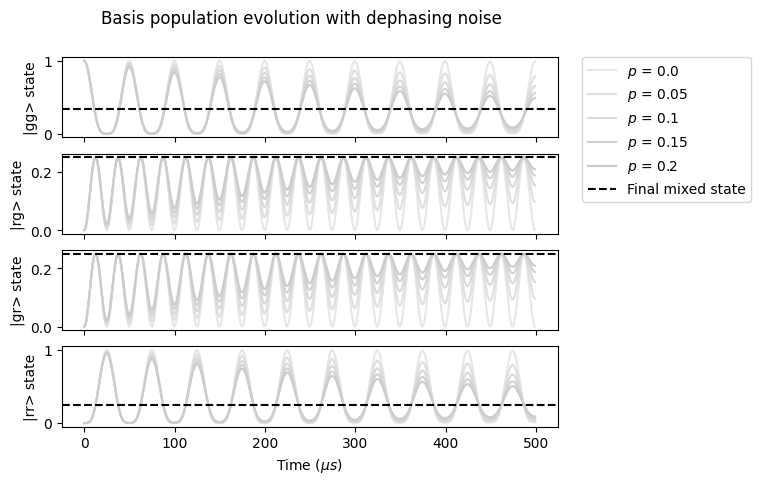

In [29]:
fig, axs = plt.subplots(4)
fig.suptitle("Basis population evolution with dephasing noise")
axs.flat[0].set(xlabel=r"Time ($\mu s$)", ylabel="|gg> state")
axs.flat[1].set(xlabel=r"Time ($\mu s$)", ylabel="|rg> state")
axs.flat[2].set(xlabel=r"Time ($\mu s$)", ylabel="|gr> state")
axs.flat[3].set(xlabel=r"Time ($\mu s$)", ylabel="|rr> state")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plot_basis_population(
    basis["gg"],
    dephasing_results,
    noise_probabilities,
    None,
    axs[0],
    1 / 3,
    True,
)
plot_basis_population(
    basis["rg"], dephasing_results, noise_probabilities, None, axs[1], 1 / 4
)
plot_basis_population(
    basis["gr"], dephasing_results, noise_probabilities, None, axs[2], 1 / 4
)
plot_basis_population(
    basis["rr"], dephasing_results, noise_probabilities, None, axs[3], 1 / 4
)
plt.show()

Without the interaction, both qubits now evolve independently towards the maximally mixed state, resulting in

$$
\rho = \frac{1}{4} (\ket{gg}\bra{gg} + \ket{gr}\bra{gr} + \ket{rg}\bra{rg} + \ket{rr}\bra{rr})
$$

#### Depolarizing Channel

In the following we illustrate the results of the two-qubit depolarizing channel.

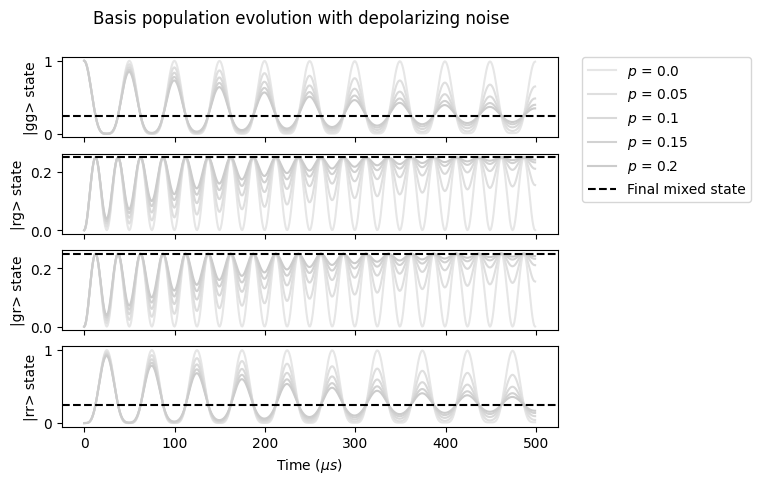

In [30]:
fig, axs = plt.subplots(4)
fig.suptitle("Basis population evolution with depolarizing noise")
axs.flat[0].set(xlabel=r"Time ($\mu s$)", ylabel="|gg> state")
axs.flat[1].set(xlabel=r"Time ($\mu s$)", ylabel="|rg> state")
axs.flat[2].set(xlabel=r"Time ($\mu s$)", ylabel="|gr> state")
axs.flat[3].set(xlabel=r"Time ($\mu s$)", ylabel="|rr> state")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plot_basis_population(
    basis["gg"],
    depolarizing_results,
    noise_probabilities,
    None,
    axs[0],
    1 / 4,
    True,
)
plot_basis_population(
    basis["rg"], depolarizing_results, noise_probabilities, None, axs[1], 1 / 4
)
plot_basis_population(
    basis["gr"], depolarizing_results, noise_probabilities, None, axs[2], 1 / 4
)
plot_basis_population(
    basis["rr"], depolarizing_results, noise_probabilities, None, axs[3], 1 / 4
)
plt.show()

Although the output state remains the same as before, we observe a different behaviour in the evolution towards it. In fact, without the interaction, we now see that the $\ket{rr}$ population oscillates freely, which did not occur in the presence of a Rydberg blockade.
